# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [191]:
import requests
import tarfile
import os
import time
import warnings
from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, stats, chi2_contingency
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (accuracy_score, recall_score, f1_score, roc_auc_score, classification_report,
                             roc_curve, precision_score, precision_recall_curve, silhouette_score)
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer

%matplotlib inline

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Automatically adjust width
pd.set_option('display.max_colwidth', None)  

In [192]:
# Downloading the data
def download_and_extract(url, extract_to='.'):
    """
    Downloads a tar.gz file from a URL and extracts it to a directory.
    Args:
    - url (str): URL of the tar.gz file to download.
    - extract_to (str): Directory path to extract the contents of the tar.gz file.
    """
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Download the file
    print("Downloading the file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.raw.read())
        print("Download completed.")
    else:
        print("Failed to download the file.")
        return

    # Extract the tar.gz file
    print("Extracting the file...")
    try:
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print("Extraction completed.")
    except Exception as e:
        print(f"Failed to extract the file: {e}")
    finally:
        # Optionally remove the tar.gz file after extraction
        os.remove(filename)
        print("Downloaded tar.gz file removed.")

# URL of the tar.gz file
url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# Call the function with the URL
download_and_extract(url)



Download completed.
Extracting the file...
Extraction completed.
Downloaded tar.gz file removed.


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [193]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [194]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [195]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

### Part 0.1: Customers & Population Data - Data Cleaning

Given that the dataframes are closely related and will be compared to each other in the end, it makes sense to do the analysis and cleaning for both in parallel


In [196]:
# Looking into the df's shapes
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [197]:
# Checking for duplicates
print(azdias.duplicated().sum())
print(customers.duplicated().sum())

0
0


In [198]:
# Checking for Nulls
azdias.isna().sum().sort_values(ascending=False)

ALTER_KIND4                    890016
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
EXTSEL992                      654153
KK_KUNDENTYP                   584612
ALTERSKATEGORIE_FEIN           262947
D19_VERSAND_ONLINE_QUOTE_12    257113
D19_LOTTO                      257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_LETZTER_KAUF_BRANCHE       257113
D19_SOZIALES                   257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_TELKO_ONLINE_QUOTE_12      257113
KBA05_DIESEL                   133324
KBA05_CCM4                     133324
KBA05_GBZ                      133324
KBA05_FRAU                     133324
KBA05_ZUL4                     133324
KBA05_HERST1                   133324
KBA05_HERST2                   133324
KBA05_HERST3                   133324
KBA05_CCM3                     133324
KBA05_HERST5                   133324
KBA05_KRSAQU

In [199]:
# Checking for Nulls
customers.isna().sum()

LNR                                 0
AGER_TYP                            0
AKT_DAT_KL                      46596
ALTER_HH                        46596
ALTER_KIND1                    179886
ALTER_KIND2                    186552
ALTER_KIND3                    190377
ALTER_KIND4                    191416
ALTERSKATEGORIE_FEIN            51842
ANZ_HAUSHALTE_AKTIV             49927
ANZ_HH_TITEL                    52110
ANZ_KINDER                      46596
ANZ_PERSONEN                    46596
ANZ_STATISTISCHE_HAUSHALTE      49927
ANZ_TITEL                       46596
ARBEIT                          50476
BALLRAUM                        49959
CAMEO_DEU_2015                  50428
CAMEO_DEUG_2015                 50428
CAMEO_INTL_2015                 50428
CJT_GESAMTTYP                    3213
CJT_KATALOGNUTZER                3213
CJT_TYP_1                        3213
CJT_TYP_2                        3213
CJT_TYP_3                        3213
CJT_TYP_4                        3213
CJT_TYP_5   

## Treating Null values listed as numerical values 
- The file DIAS Attributes - Values 2017.csv provided with the dataset explains the numerical values encoded as variable per feature in our data.
- While we do have explicit Nulls already in the datasets, it appear there are a lot of numerical values assigned when the value is "Unknown".
- Before determining how to deal with Nulls in our data (Imputate, Delete, etc.), we'll need to have them all converted to the same format as NaN values.

**Steps:**
1. Review data types: Make sure all columns with numerical nulls are a numerical dtype
2. Define criteria: Determine the columns with the numerical nulls to be converted
3. Convert valus to np.nan

- **All Values of "-1" indicate a NULL.**

- **All Values of "0" in the columns below indicate a NULL:**
    - D19_BANKEN_OFFLINE_DATUM, CJT_GESAMTTYP, GEBAEUDETYP, GEOSCORE_KLS7, HAUSHALTSSTRUKTUR, HEALTH_TYP, HH_EINKOMMEN_SCORE, 
      KBA05_BAUMAX, NATIONALITAET_KZ, PRAEGENDE_JUGENDJAHRE, REGIOTYP, RETOURTYP_BK_S, TITEL_KZ, WOHNDAUER_2008
      WOHNLAGE, WACHSTUMSGEBIET_NB, W_KEIT_KIND_HH
      

- **All Values of "9" in the columns below indicate a NULL:**
    1. ZABEOTYP
    2. Column Name STARTS WITH "KBA05"
    3. Column Name STARTS WITH "SEMIO"



In [200]:
non_numerical_columns_azdias = azdias.select_dtypes(exclude=['number']).columns
non_numerical_columns_azdias

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [201]:
non_numerical_columns_customers = customers.select_dtypes(exclude=['number']).columns
non_numerical_columns_customers

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

In [202]:
# Converting columns wrongly saved as object to numerical
azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].replace(['X','XX'], np.nan)
azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].apply(
    pd.to_numeric)


In [203]:
# Converting columns wrongly saved as object to numerical

customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].replace(['X','XX'], np.nan)
customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].apply(
    pd.to_numeric)


In [204]:

# Define columns for each rule
columns_for_zeros = [
    'D19_BANKEN_OFFLINE_DATUM', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 
    'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 
    'REGIOTYP', 'RETOURTYP_BK_S', 'TITEL_KZ', 'WOHNDAUER_2008', 'WOHNLAGE', 
    'W_KEIT_KIND_HH'
]

columns_for_nines = ['ZABEOTYP'] + [col for col in azdias.columns if col.startswith('KBA05')] + [col for col in azdias.columns if col.startswith('SEMIO')]

# Replace -1 with Nulls
azdias.replace(-1, np.nan, inplace=True)

azdias[columns_for_zeros] = azdias[columns_for_zeros].replace(0, np.nan, inplace=True)

# Replace 9 in the specified columns with NaN
azdias[columns_for_nines] = azdias[columns_for_nines].replace(9, np.nan)


In [205]:
# Define columns for each rule
columns_for_zeros = [
    'D19_BANKEN_OFFLINE_DATUM', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 
    'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 
    'REGIOTYP', 'RETOURTYP_BK_S', 'TITEL_KZ', 'WOHNDAUER_2008', 'WOHNLAGE', 
    'W_KEIT_KIND_HH'
]

columns_for_nines = ['ZABEOTYP'] + [col for col in azdias.columns if col.startswith('KBA05')] + [col for col in azdias.columns if col.startswith('SEMIO')]

# Replace -1 with Nulls
customers.replace(-1, np.nan, inplace=True)

customers[columns_for_zeros] = customers[columns_for_zeros].replace(0, np.nan, inplace=True)

# Replace 9 in the specified columns with NaN
customers[columns_for_nines] = customers[columns_for_nines].replace(9, np.nan)


In [206]:
def create_null_table(df):

    """
    INPUT: 
    df: dataframe to be processed

    OUTPUT:
    null_df: dataframe of all the df's columns with the null values within each column and the null% out of all rows in the df.
    output is sorted descendingly
    
    
    """
    null_df = df.isna().sum()
    null_df = null_df.reset_index()
    null_df = null_df.sort_values(by=0,ascending=False)
    null_df.columns = ['feature', 'null_count']

    null_df['percentage'] = null_df['null_count']/(df.shape[0])

    return null_df

def drop_mostly_na_cols(df):

    """
    INPUT: 
    df: dataframe to be processed

    OUTPUT:
    null_df: Same dataframe excluding columns with more than 50% Null values.
    
    
    """
    
    df_null = create_null_table(df)
    df_drop_cols = df_null.loc[df_null['percentage'] > 0.5, 'feature'].tolist()
    
    if df_drop_cols:
        print(f"Dropping columns with more than 50% Null values: {df_drop_cols}")
        df.drop(columns=df_drop_cols, inplace=True)
    else:
        print("No columns with more than 50% Null values to drop.")
    
    return df



def fill_numerical_na_with_mean_and_convert(df, exclude_cols=None):
    """    
    INPUT:
    df (pd.DataFrame): The DataFrame to process.
    exclude_cols (list): A list of columns to exclude from processing.
    
    Returns:
    df(pd.DataFrame): The DataFrame with numerical columns' NaNs filled with mean and columns converted to int.
    """
    if exclude_cols is None:
        exclude_cols = []

    # Step 1: Filter columns with dtype float or int, excluding specified columns
    filtered_columns = df.select_dtypes(include=['float', 'int']).drop(columns=exclude_cols, errors='ignore')

    # Step 2: Fill NaN values with the mean of each column
    filled_columns = filtered_columns.fillna(filtered_columns.mean())

    # Step 3: Convert columns to int
    filled_columns = filled_columns.astype(int)

    # Step 4: Update the original DataFrame
    df.update(filled_columns)

    print("Numerical columns' nulls have been successfully replaced with the respective column's mean.")

    
    return df


def fill_non_num_na_with_mode_and_convert(df):

    """    
    INPUT:
    df (pd.DataFrame): The DataFrame to process.
    
    Returns:
    df(pd.DataFrame): The DataFrame with non-numerical columns' NaNs filled with mode.
    """
    
    df_null = create_null_table(df)    

    df_null_list = df_null.loc[df_null['null_count'] > 0, 'feature'].tolist()

    object_columns = df.select_dtypes(include='object').columns
    
    # Filter df_null_list to include only features that are also in object_columns
    df_obj_null_list = [feature for feature in df_null_list if feature in object_columns]
    
    for feature in df_obj_null_list:

        most_frequent_value = df[feature].mode()[0]
    
        df[feature].fillna(most_frequent_value, inplace=True)

    print("Categorical columns' nulls have been successfully replaced with the respective column's mode.")

    return df

def clean_nulls(df, exclude_cols=None):

    """   
    Main function to call and process all nulls.
    
    INPUT:
    df (pd.DataFrame): The DataFrame to process.
    exclude_cols (list): A list of numerical dtype columns to exclude from processing.
    
    Returns:
    df(pd.DataFrame): The DataFrame with all Null values properly processed.
    """
    
    # Drop columns with more than 50% nulls
    df = drop_mostly_na_cols(df)
    
    # Fill numerical columns' nulls
    df = fill_numerical_na_with_mean_and_convert(df, exclude_cols=exclude_cols)
    
    # Fill categorical columns' nulls
    df = fill_non_num_na_with_mode_and_convert(df)

    # Print out the remaining null count
    print(f"Remaining Nulls in df: {df.isna().any().sum()}")
    
    return df


In [207]:
# Filling the nulls in azdias population df, while excluding the LNR identifier column from the process
azdias = clean_nulls(azdias, exclude_cols=['LNR'])

Dropping columns with more than 50% Null values: ['NATIONALITAET_KZ', 'HEALTH_TYP', 'W_KEIT_KIND_HH', 'D19_BANKEN_OFFLINE_DATUM', 'KBA05_BAUMAX', 'RETOURTYP_BK_S', 'CJT_GESAMTTYP', 'REGIOTYP', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ', 'WOHNDAUER_2008', 'HH_EINKOMMEN_SCORE', 'WOHNLAGE', 'GEBAEUDETYP', 'ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP']
Numerical columns' nulls have been successfully replaced with the respective column's mean.
Categorical columns' nulls have been successfully replaced with the respective column's mode.
Remaining Nulls in df: 0


In [208]:
# Filling the nulls in customers df, while excluding the LNR identifier column and the 3 unique customer columns from the process
customers = clean_nulls(customers, exclude_cols=['LNR','CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

Dropping columns with more than 50% Null values: ['REGIOTYP', 'TITEL_KZ', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH', 'RETOURTYP_BK_S', 'PRAEGENDE_JUGENDJAHRE', 'CJT_GESAMTTYP', 'D19_BANKEN_OFFLINE_DATUM', 'KBA05_BAUMAX', 'NATIONALITAET_KZ', 'WOHNLAGE', 'GEBAEUDETYP', 'HH_EINKOMMEN_SCORE', 'HEALTH_TYP', 'ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP']
Numerical columns' nulls have been successfully replaced with the respective column's mean.
Categorical columns' nulls have been successfully replaced with the respective column's mode.
Remaining Nulls in df: 0


In [209]:
customers.isna().any().sum()

0

In [210]:
azdias.isna().any().sum()

0

### Part 0.2: Customers & Population Data - Data Pre-processing & Feature Engineering

This section tackles all pre-processing steps before applying clustering algorithms on our data.


In [211]:
# Exclude irrelevant columns to create `cseg` and 'pseg' for customer segment and population segment.
cseg = customers.drop(columns=['LNR','CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP','EINGEFUEGT_AM'])
pseg = azdias.drop(columns=['LNR','EINGEFUEGT_AM'])


In [212]:
pseg.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')

In [213]:
cseg.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')

### Features Review

1. **CAMEO_DEU_2015:** This column includes categorical classification to individuals based on consumer demographic data.
    - This column is currently encoded as an object (1A to 9E)
    - This columns is an oridnal categorization of population. Therefore label encoding would be better suited.

2. **D19_LETZTER_KAUF_BRANCHE:** This column contains text data about the consumer sector with the individual's latest transactional behaviour.

   
    - This information is encapulated by the other D19_ columns with numerical encoded indexing for the customer's transactional behaviour.
    - OneHot encoding this column would vastly expand our dataset.
    - This column should be dropped.

      
4. **OST_WEST_KZ:** This columns entails where the individual's region used to lie in post-WW2 split Germany.

    
    - For Null values, there is no data point to use to determine the individual's location (e.g. Postcode)
    - Currently it was processed by filling the nulls with the mode, however the null ratio of the column was too large.
    - Dropping this column would be the safest course.
  
   

In [214]:
cseg = cseg.drop(columns=['D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ'])
pseg = pseg.drop(columns=['D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ'])

In [215]:
cseg.shape

(191652, 343)

In [216]:
pseg.shape

(891221, 341)

In [217]:
only_customers = set(cseg.columns)-set(pseg.columns)
only_pop = set(pseg.columns)-set(cseg.columns)

In [218]:
only_customers #These columns are still in cseg but not in pseg. 

{'AGER_TYP', 'EXTSEL992'}

In [219]:
#These extra columns must be dropped for a proper comparison and analysis between both df's.
cseg = cseg.drop(columns=["AGER_TYP", "EXTSEL992"])

In [220]:
assert pseg.shape[1] == cseg.shape[1]

In [221]:
# Perform Label Encoding on CAMEO_DEU_2015
label_encoder = LabelEncoder()

pseg['CAMEO_DEU_2015'] = label_encoder.fit_transform(pseg['CAMEO_DEU_2015'])
cseg['CAMEO_DEU_2015'] = label_encoder.transform(cseg['CAMEO_DEU_2015'])


In [222]:
cseg.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

In [223]:
pseg.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

In [224]:
# Standardize the data
scaler = StandardScaler()
pseg_scaled = scaler.fit_transform(pseg)
cseg_scaled = scaler.transform(cseg)

In [225]:
# Convert scaled data back to DataFrame with appropriate column names
pseg_scaled_df = pd.DataFrame(pseg_scaled, columns=pseg.columns)
cseg_scaled_df = pd.DataFrame(cseg_scaled, columns=cseg.columns)

In [226]:
# Perform PCA
pca = PCA(random_state = 42)
pca.fit(pseg_scaled_df)

# Get the component loadings
loadings = pca.components_

# Check that the number of columns in the DataFrame matches the number of features in PCA
if loadings.shape[1] == pseg_scaled_df.shape[1]:
    print("The number of features in the PCA loadings matches the number of columns in the DataFrame.")
else:
    print(f"Warning: PCA components' column count ({loadings.shape[1]}) does not match DataFrame columns ({pseg_scaled_df.shape[1]}).")

# Create a DataFrame of the loadings with feature names as columns
loadings_df = pd.DataFrame(loadings, columns=pseg_scaled_df.columns)
print("\nSummary of PCA Component Loadings df has been created")

The number of features in the PCA loadings matches the number of columns in the DataFrame.

Summary of PCA Component Loadings df has been created


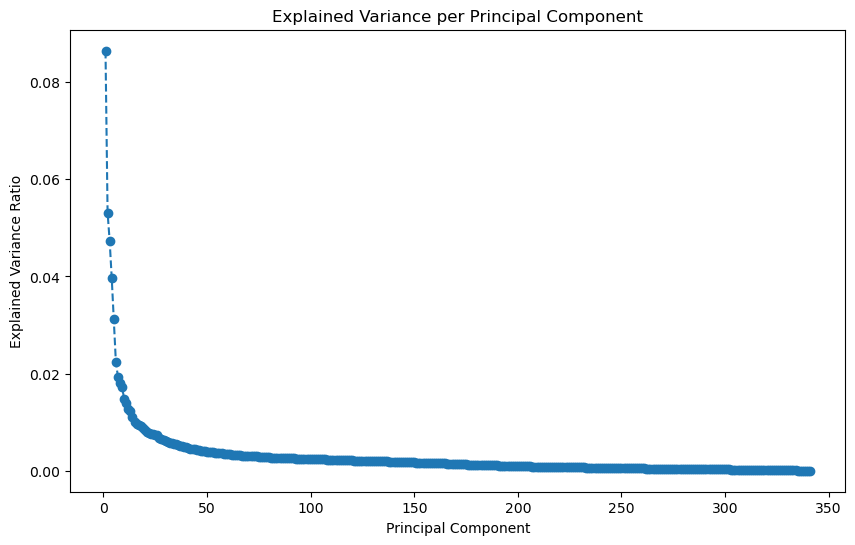

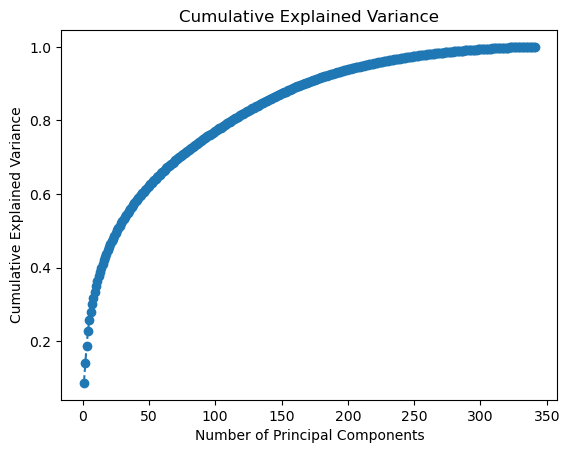

Principal Component 10: 8.65% cumulative explained variance
Principal Component 11: 13.97% cumulative explained variance
Principal Component 12: 18.70% cumulative explained variance
Principal Component 13: 22.67% cumulative explained variance
Principal Component 14: 25.80% cumulative explained variance
Principal Component 15: 28.04% cumulative explained variance
Principal Component 16: 29.97% cumulative explained variance
Principal Component 17: 31.79% cumulative explained variance
Principal Component 18: 33.50% cumulative explained variance
Principal Component 19: 34.99% cumulative explained variance
Principal Component 20: 36.37% cumulative explained variance
Principal Component 21: 37.65% cumulative explained variance
Principal Component 22: 38.87% cumulative explained variance
Principal Component 23: 39.99% cumulative explained variance
Principal Component 24: 40.98% cumulative explained variance
Principal Component 25: 41.94% cumulative explained variance
Principal Component 26: 4

In [227]:
# Plot the explained variance ratio (Scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Print the cumulative variance to find the optimal number of components
for i, var in enumerate(cumulative_variance):
    print(f"Principal Component {i + 10}: {var * 100:.2f}% cumulative explained variance")

In [228]:
# 176 principal components explain 90% of the cumulative variance

optimal_components = 176  # Replace with the optimal number based on your analysis

# Perform PCA with the selected number of components
pca = PCA(n_components=optimal_components, random_state=42)
p_reduced = pca.fit_transform(pseg_scaled)
c_reduced = pca.transform(cseg_scaled)

# Convert reduced data back to a DataFrame for further analysis
p_reduced_df = pd.DataFrame(p_reduced, columns=[f'PC{i+1}' for i in range(optimal_components)])
c_reduced_df = pd.DataFrame(c_reduced, columns=[f'PC{i+1}' for i in range(optimal_components)])


In [229]:
p_reduced_df.shape

(891221, 176)

In [230]:
c_reduced_df.shape

(191652, 176)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**Due to the nature of the datasets and our objective, I'll try out two clustering algorithms: K-Means & Gaussian Mixture Model. We'll evaluate which model to proceed with by reviewing the silhouette score per model fitting.**

### K-Means

Processing number of clusters: 24...
Fitting complete, calculating inertia...
  -------------------------------------


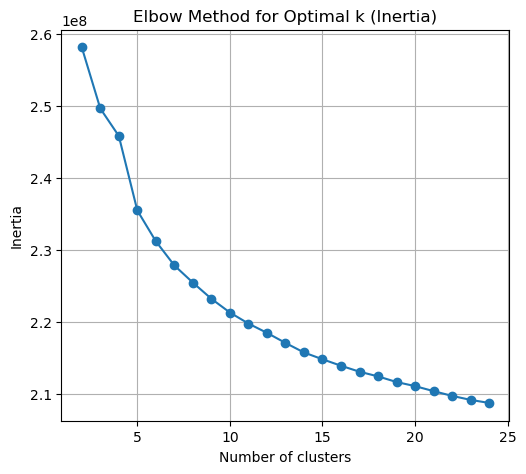

In [231]:
# Applying The Elbow Method for determining the Optimal K.

inertia = []
range_n_clusters = range(2, 25)  # Start from 2 because silhouette score is not defined for 1 cluster

# Loop through different numbers of clusters to compute inertia and silhouette score
for n_clusters in range_n_clusters:
    clear_output(wait=True)  # Clear previous output
    print(f"Processing number of clusters: {n_clusters}...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit the model
    kmeans.fit(p_reduced_df)
    print("Fitting complete, calculating inertia...")
    
    # Compute inertia
    inertia_value = kmeans.inertia_
    inertia.append(inertia_value)
    
    # Pause briefly to update the output
    time.sleep(0.5)  # Simulate work or prevent rapid updates

    print("  -------------------------------------")

# Plot the Elbow Curve for Inertia
plt.figure(figsize=(10, 5))

# Elbow plot for Inertia
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k (Inertia)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.tight_layout()
plt.show()


In [232]:
inertia

[258140174.62245333,
 249641971.8774755,
 245827141.0580548,
 235474291.31101373,
 231199597.23846632,
 227840501.27531815,
 225457230.54058868,
 223209551.49383813,
 221299813.90591645,
 219770021.30068672,
 218480083.14416438,
 217079621.94952095,
 215753258.43824846,
 214809368.4449218,
 213910501.58658057,
 213078876.2312906,
 212431062.55067927,
 211649423.73319024,
 211080194.55651805,
 210382200.9090845,
 209724932.06958106,
 209167510.04433206,
 208743939.10165185]

In [233]:
# Based on Inertia figures, the optimal K is 10. This will be applied to the K-Means model.

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(p_reduced_df)

KMeans(n_clusters=10, random_state=42)

In [239]:
# Adding the clusters labels as a column to the population df.
p_reduced_df['cluster'] = kmeans.labels_

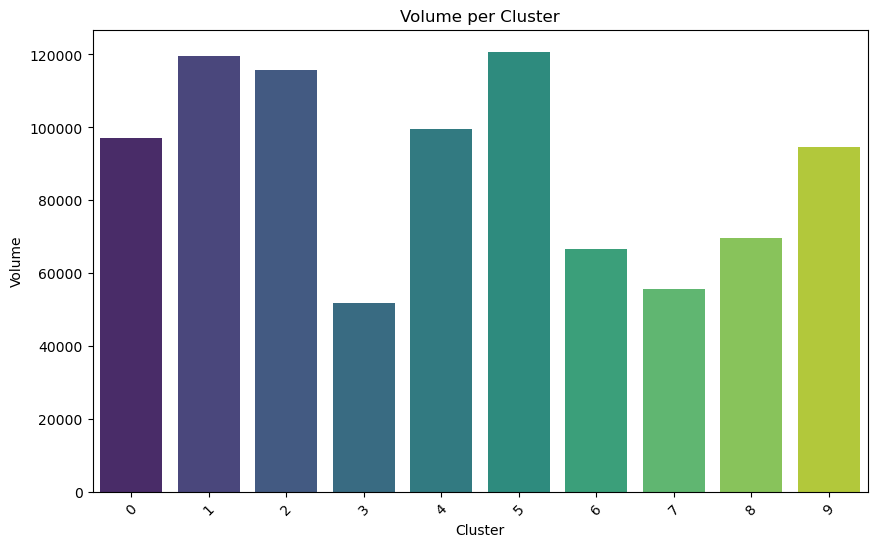

In [240]:
# Count the number of data points in each cluster
cluster_counts = p_reduced_df['cluster'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Volume per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()


<Figure size 1200x600 with 0 Axes>

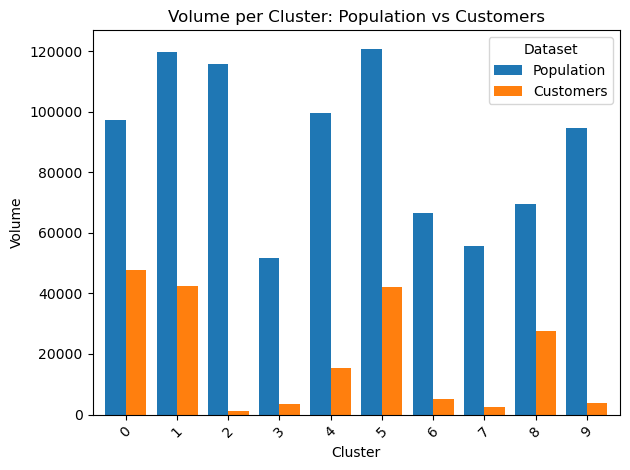

In [241]:
# Applying the clustering structure to the customers df.
c_reduced_df['cluster'] = kmeans.predict(c_reduced_df)

# Count the number of data points in each cluster for the population and customer datasets
cluster_counts_population = p_reduced_df['cluster'].value_counts().sort_index()
cluster_counts_customers = c_reduced_df['cluster'].value_counts().sort_index()

# Combine the cluster counts into a single DataFrame for easier plotting
cluster_counts_combined = pd.DataFrame({
    'Population': cluster_counts_population,
    'Customers': cluster_counts_customers
}).fillna(0)  # Fill NaN values with 0 (if any clusters are missing in one of the datasets)

# Plotting the combined bar chart
plt.figure(figsize=(12, 6))
cluster_counts_combined.plot(kind='bar', width=0.8)

plt.title('Volume per Cluster: Population vs Customers')
plt.xlabel('Cluster')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()

# Display the plot
plt.show()

In [242]:
# Calculate the percentage of total population and total customers in each cluster
population_percentages = (cluster_counts_population / cluster_counts_population.sum()) * 100
customer_percentages = (cluster_counts_customers / cluster_counts_customers.sum()) * 100

# Create a DataFrame to view the comparison
comparison_df = pd.DataFrame({
    'Population Percentage': population_percentages,
    'Customer Percentage': customer_percentages
}).fillna(0)  # Fill missing values (if any clusters are missing from customer data)

# Print the comparison
print(comparison_df)


         Population Percentage  Customer Percentage
cluster                                            
0                    10.901224            24.942083
1                    13.423045            22.135433
2                    12.995766             0.649093
3                     5.808099             1.896667
4                    11.174557             8.058356
5                    13.554887            21.994553
6                     7.472557             2.616722
7                     6.239305             1.363930
8                     7.809960            14.404754
9                    10.620598             1.938409


In [243]:
# Calculate percentage difference between customer and population percentages to determine clusters with over-representation of customers.
comparison_df['Percentage Difference'] = comparison_df['Customer Percentage'] - comparison_df['Population Percentage']

# Print the comparison with the difference
print(comparison_df.sort_values(by='Percentage Difference', ascending=False))


         Population Percentage  Customer Percentage  Percentage Difference
cluster                                                                   
0                    10.901224            24.942083              14.040858
1                    13.423045            22.135433               8.712388
5                    13.554887            21.994553               8.439666
8                     7.809960            14.404754               6.594795
4                    11.174557             8.058356              -3.116201
3                     5.808099             1.896667              -3.911432
6                     7.472557             2.616722              -4.855835
7                     6.239305             1.363930              -4.875375
9                    10.620598             1.938409              -8.682189
2                    12.995766             0.649093             -12.346673


In [244]:
# Create a contingency table with the counts of customers and population in each cluster
contingency_table = pd.concat([cluster_counts_population, cluster_counts_customers], axis=1, keys=['Population', 'Customers'])

# Perform the Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the test result
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Counts:\n{expected}")

# Interpretation of p-value
if p_value < 0.05:
    print("There is a significant difference between the population and customer distribution across clusters.")
else:
    print("There is no significant difference between the population and customer distribution across clusters.")


Chi-Square Statistic: 100425.0711093934
P-value: 0.0
Degrees of Freedom: 9
Expected Counts:
[[119300.99954104  25655.00045896]
 [133371.2683685   28680.7316315 ]
 [ 96346.28101818  20718.71898182]
 [ 45593.39918716   9804.60081284]
 [ 94674.73703195  20359.26296805]
 [134116.09717575  28840.90282425]
 [ 58937.76855827  12674.23144173]
 [ 47915.94824139  10304.05175861]
 [ 80006.13611291  17204.86388709]
 [ 80958.36476484  17409.63523516]]
There is a significant difference between the population and customer distribution across clusters.


In [245]:
# Add cluster labels to the original data
cseg['cluster'] = c_reduced_df['cluster']

# Group by cluster and calculate summary statistics for each feature
cluster_summary = cseg.groupby('cluster').mean()

In [246]:
# Specify the target clusters we want to compare
target_clusters = [0, 1, 2, 7]
p_values = {}  # Dictionary to store p-values for each feature
mean_diff = {}  # Dictionary to store mean difference for each feature

# Loop through each of the target clusters
for cluster in target_clusters:
    p_values[cluster] = {}  # Store p-values for the current cluster
    mean_diff[cluster] = {}  # Store mean differences for the current cluster
    
    # Loop through each feature in the cluster summary
    for feature in cluster_summary.columns:
        # Extract the values for the current cluster (cluster `cluster`)
        cluster_values = cluster_summary.loc[cluster, feature]
        
        # Extract values for the other clusters (excluding the current cluster)
        other_clusters_values = cluster_summary.loc[cluster_summary.index != cluster, feature].dropna()
        
        # Repeat the scalar value for the current cluster to match the size of the other clusters
        cluster_values_repeated = [cluster_values] * len(other_clusters_values)
        
        # Mean difference
        mean_diff[cluster][feature] = cluster_values - other_clusters_values.mean()
        
        # T-test
        t_stat, p_val = ttest_ind(cluster_values_repeated, other_clusters_values, equal_var=False)
        p_values[cluster][feature] = p_val

# Filter significant p-values (e.g., p < 0.05) for each cluster
significant_features = {}
for cluster in target_clusters:
    significant_features[cluster] = {k: v for k, v in p_values[cluster].items() if v < 0.05}

In [247]:
# Specify the target clusters we want to compare
target_clusters = [0, 1, 2, 7]
cohen_d_values = {}  # Dictionary to store Cohen's d values for each feature

# Loop through each of the target clusters
for cluster in target_clusters:
    cohen_d_values[cluster] = {}  # Store Cohen's d values for the current cluster
    
    # Loop through each feature in the cluster summary
    for feature in cluster_summary.columns:
        # Extract the values for the current cluster (cluster `cluster`)
        cluster_values = cluster_summary.loc[cluster, feature]
        
        # Extract values for the other clusters (excluding the current cluster)
        other_clusters_values = cluster_summary.loc[cluster_summary.index != cluster, feature].dropna()
        
        # Calculate pooled standard deviation (for the values from other clusters)
        pooled_std = np.std(other_clusters_values, ddof=1)  # Using ddof=1 for sample std
        
        # Calculate Cohen's d: (mean of group 1 - mean of group 2) / pooled standard deviation
        cohen_d = (cluster_values - other_clusters_values.mean()) / pooled_std
        cohen_d_values[cluster][feature] = cohen_d

# Now cohen_d_values contains the Cohen's d for each feature per cluster

In [248]:
# Create an empty list to store the rows for the DataFrame
cluster_results = []

# Loop through each of the target clusters
for cluster in target_clusters:
    # Loop through each feature in the cluster summary
    for feature in cluster_summary.columns:
        # Store the mean difference, p-value, and Cohen's d for each feature in the cluster
        mean_diff_value = mean_diff[cluster].get(feature, np.nan)
        p_value = p_values[cluster].get(feature, np.nan)
        cohen_d_value = cohen_d_values[cluster].get(feature, np.nan)

        # Append the results as a dictionary (for each feature in each cluster)
        cluster_results.append({
            'Cluster': cluster,
            'Feature': feature,
            'Mean Difference': mean_diff_value,
            'P-value': p_value,
            'Cohen\'s d': cohen_d_value
        })

# Convert the list of dictionaries into a DataFrame
cluster_results_df = pd.DataFrame(cluster_results)

# Round Cohen's d to 1 decimal place
cluster_results_df['Cohen\'s d'] = cluster_results_df['Cohen\'s d'].round(1)

# Filter results to show significant differences only
significant_cluster_results_df = cluster_results_df[
    (cluster_results_df['P-value'] < 0.05) & (cluster_results_df['Cohen\'s d'].abs() > 0.5)
]

# Sort the results by Cohen's d in descending order
significant_cluster_results_df = significant_cluster_results_df.sort_values(by='Cohen\'s d', ascending=False)

In [249]:
# Create an empty dictionary to store the DataFrames for each cluster
cluster_dfs = {}

# Create and filter the DataFrame for each cluster
for cluster in target_clusters:
    # Create a DataFrame for the current cluster results
    cluster_results_df = pd.DataFrame({
        'Feature': list(cluster_summary.columns),
        'Mean Difference': [mean_diff[cluster].get(feature, None) for feature in cluster_summary.columns],
        'P-value': [p_values[cluster].get(feature, None) for feature in cluster_summary.columns],
        'Cohen\'s d': [cohen_d_values[cluster].get(feature, None) for feature in cluster_summary.columns]
    })
    
    # Round Cohen's d values
    cluster_results_df['Cohen\'s d'] = cluster_results_df['Cohen\'s d'].round(1)
    
    # Filter results to show significant differences (p-value < 0.05 and Cohen's d > 0.5)
    significant_cluster_results_df = cluster_results_df[
        (cluster_results_df['P-value'] < 0.05) & 
        (cluster_results_df['Cohen\'s d'].abs() > 0.5)
    ]
    
    # Sort by Cohen's d value
    significant_cluster_results_df = significant_cluster_results_df.sort_values(by='Cohen\'s d', ascending=False)
    
    # Save the filtered DataFrame to the dictionary
    cluster_dfs[f'cluster_{cluster}_results'] = significant_cluster_results_df

# Now cluster_dfs will hold the DataFrame for each cluster, e.g., cluster_0_results, cluster_1_results, etc.
# To access a specific cluster's DataFrame, you can do something like:
# cluster_0_results = cluster_dfs['cluster_0_results']
# cluster_1_results = cluster_dfs['cluster_1_results']


In [255]:
cluster_0_results = cluster_dfs['cluster_0_results']
cluster_1_results = cluster_dfs['cluster_1_results']
cluster_5_results = cluster_dfs['cluster_2_results']
cluster_8_results = cluster_dfs['cluster_7_results']

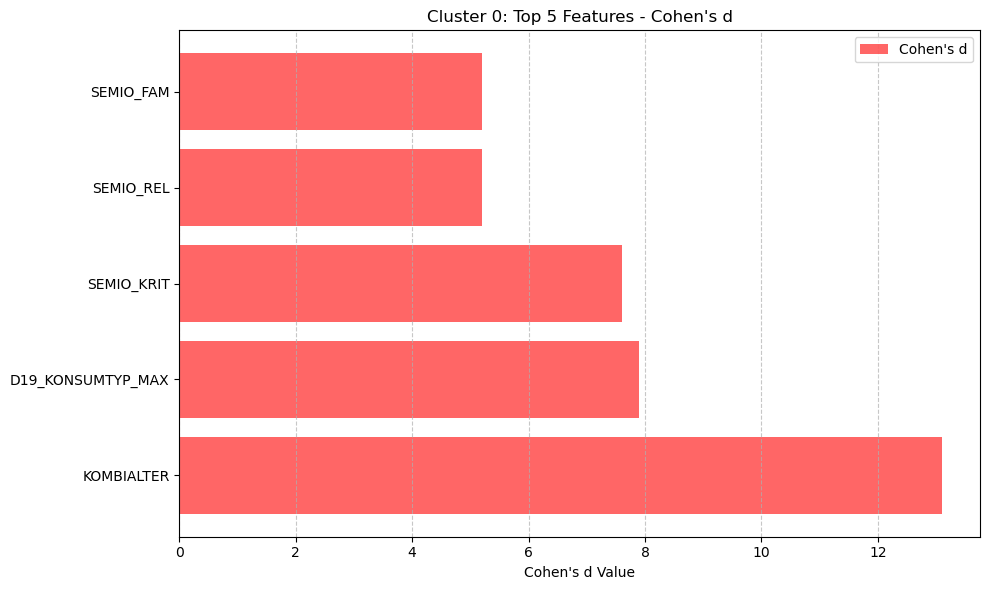

In [256]:
# Cluster 0
# Sort by the absolute value of Cohen's d in descending order and select the top 5 features
top_5_features = cluster_0_results.reindex(cluster_0_results['Cohen\'s d'].sort_values(ascending=False).head(5).index)

# Plotting only Cohen's d for the top 20 features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Cohen's d
ax.barh(top_5_features['Feature'], top_5_features['Cohen\'s d'], color='red', alpha=0.6, label="Cohen's d")

# Adding labels and title
ax.set_xlabel('Cohen\'s d Value')
ax.set_title('Cluster 0: Top 5 Features - Cohen\'s d')

# Adding grid and legend
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


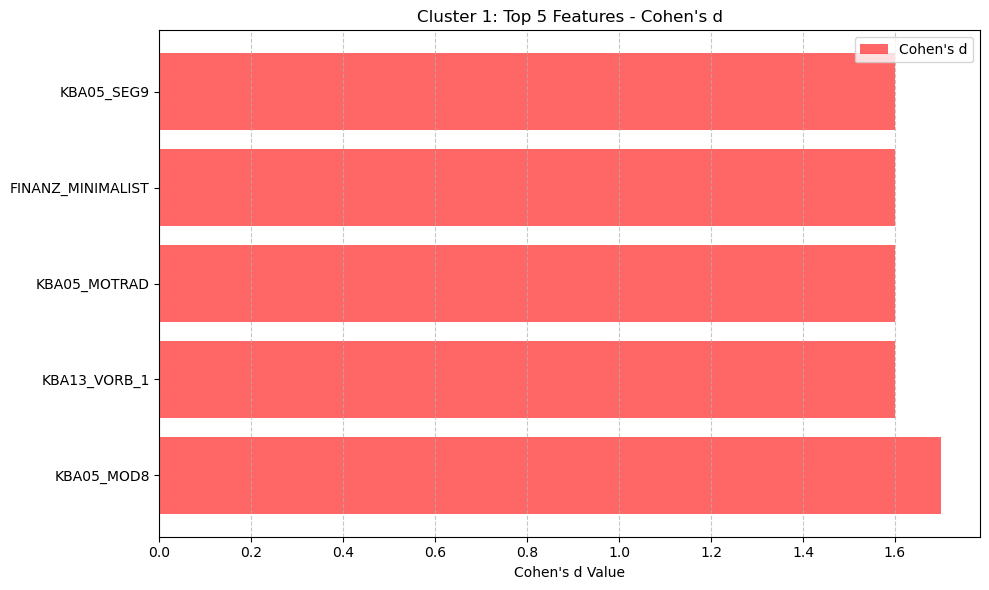

In [257]:
# Cluster 1
# Sort by the absolute value of Cohen's d in descending order and select the top 20
top_5_features = cluster_1_results.reindex(cluster_1_results['Cohen\'s d'].sort_values(ascending=False).head(5).index)

# Plotting only Cohen's d for the top 20 features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Cohen's d
ax.barh(top_5_features['Feature'], top_5_features['Cohen\'s d'], color='red', alpha=0.6, label="Cohen's d")

# Adding labels and title
ax.set_xlabel('Cohen\'s d Value')
ax.set_title('Cluster 1: Top 5 Features - Cohen\'s d')

# Adding grid and legend
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


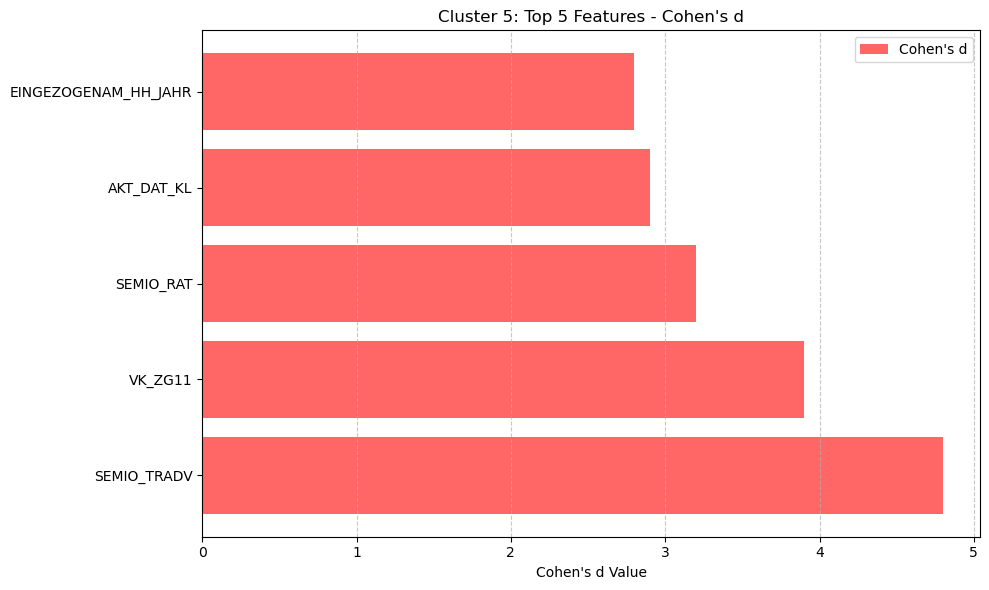

In [258]:
# Cluster 5
# Sort by the absolute value of Cohen's d in descending order and select the top 20
top_5_features = cluster_5_results.reindex(cluster_5_results['Cohen\'s d'].sort_values(ascending=False).head(5).index)

# Plotting only Cohen's d for the top 20 features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Cohen's d
ax.barh(top_5_features['Feature'], top_5_features['Cohen\'s d'], color='red', alpha=0.6, label="Cohen's d")

# Adding labels and title
ax.set_xlabel('Cohen\'s d Value')
ax.set_title('Cluster 5: Top 5 Features - Cohen\'s d')

# Adding grid and legend
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


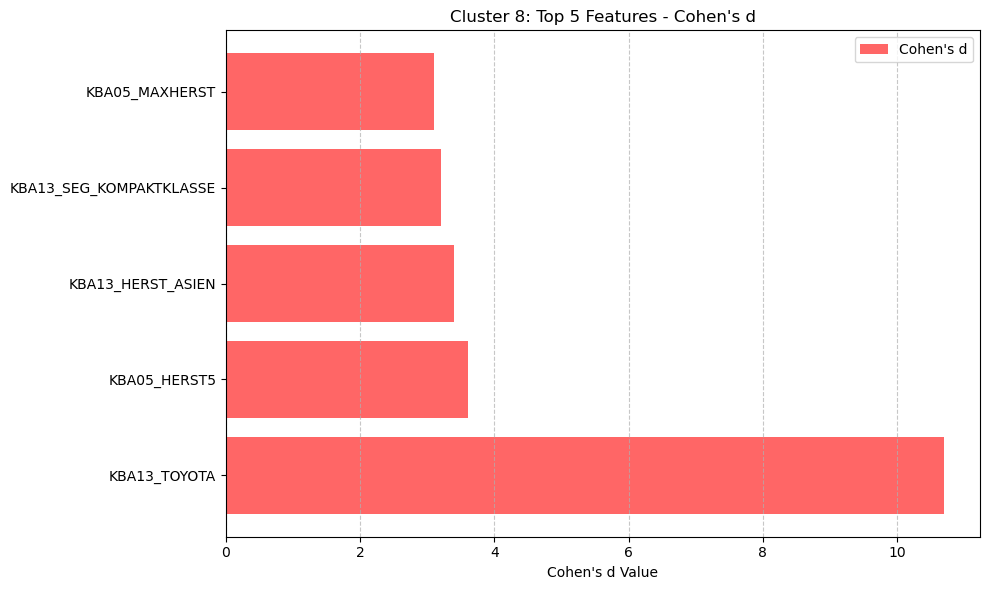

In [259]:
# Cluster 8
# Sort by the absolute value of Cohen's d in descending order and select the top 20
top_5_features = cluster_8_results.reindex(cluster_8_results['Cohen\'s d'].sort_values(ascending=False).head(5).index)

# Plotting only Cohen's d for the top 20 features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Cohen's d
ax.barh(top_5_features['Feature'], top_5_features['Cohen\'s d'], color='red', alpha=0.6, label="Cohen's d")

# Adding labels and title
ax.set_xlabel('Cohen\'s d Value')
ax.set_title('Cluster 8: Top 5 Features - Cohen\'s d')

# Adding grid and legend
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()
